# Stark map for Rydberg helium

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
print(starkhelium_version())

v0.5


In [2]:
#import inspect as insp
#insp.getsourcelines(ang_overlap)

In [3]:
# User variables
  # Whether to import the Stark interaction matrix, or calculate it
IMPORT_MAT_S = False
  # If calculating the Stark interaction matrix, whether to save it
SAVE_MAT_S = True
  # Whether to import the Stark data
IMPORT_STARK_MAP_DATA = False
  # Whether to save the Stark map data
SAVE_STARK_MAP_DATA = True
  # Whether to plot the Stark map
PLOT_STARK_MAP = True
  # If plot Stark map, whether to highlight specified lines
HIGHLIGHT_STARK_MAP_PLOT = False
  # If plot Stark map, whether to save out figure
SAVE_STARK_MAP_PLOT = True

In [4]:
def getDataDir():
    # Create data directoy if it doesn't exist
    directory = os.path.join(".", "data")
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory
def getImagesDir():
    # Create data directoy if it doesn't exist
    directory = os.path.join(".", "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

In [5]:
# quantum numbers
nmin = 69
nmax = 74
S = 1
n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals)
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
#En = En_0(neff)
# field orientation
field_orientation = 'crossed'
# field-free Hamiltonian
H_0 = np.diag(En)
# Numerov step size
numerov_step=0.001

if (IMPORT_MAT_S):
    filename = "StarkIntMatrix_n_" + str(nmin) + "-" + str(nmax) + "_step_" + str(numerov_step).replace('.', '-') + ".npy"
    directory = getDataDir()
    filein = os.path.join(directory, filename)
    try:
        mat_S = np.load(filein)
    except:
        raise
else:
    # find the off-diagonal terms of the Stark interaction matrix
    mat_S = stark_matrix(neff, L_vals, m_vals, field_orientation, numerov_step=numerov_step)
    if SAVE_MAT_S:
        # Create fileaname for Stark map
        filename = "StarkIntMatrix_n_" + str(nmin) + "-" + str(nmax)
        # Get data directoy, create it if it doesn't exist
        directory = getDataDir()
        # Save Stark interaction matrix to file
        fileout = os.path.join(directory, filename)
        np.save(fileout, mat_S)

calculate Stark terms: 100%|███████████| 30691/30691 [3:49:01<00:00,  2.23it/s]


In [11]:
# specify the electric field
field = np.linspace(3.22, 3.29, 13) # V /cm
field_au = field * 100 / (En_h_He/(e*a_0_He)) 
# specify the magnetic field (in Telsa)
B_z = 1.5776E-3
# (in atomic units)
B_z_au = B_z / (hbar/(e*a_0_He**2))
# Zeeman interaction Hamiltonian
H_Z = np.diag(E_zeeman(m_vals, B_z_au))

# Create fileaname for Stark map data
filename = "StarkMapData_n_" + str(nmin) + "-" + str(nmax) + \
"_E_" + str(np.min(field)).replace('.', '-') + "_" + str(np.max(field)).replace('.', '-') + "_" + str(len(field)) + \
"_B_" + str(B_z*1E3).replace('.', '-') + '.npy'

if (IMPORT_STARK_MAP_DATA):
    filein = os.path.join(getDataDir(), filename)
    try:
        map1 = np.load(filein)
    except:
        raise
else: 
    # diagonalise for each field
    map1 = stark_map(H_0, mat_S, field_au, H_Z=H_Z)
    if SAVE_STARK_MAP_DATA==True:
        # Save Stark map to file
        fileout = os.path.join(getDataDir(), filename)
        np.save(fileout, map1)

Plotting: 100%|████████████████████████| 6161/6161 [00:00<00:00, 616056.52it/s]


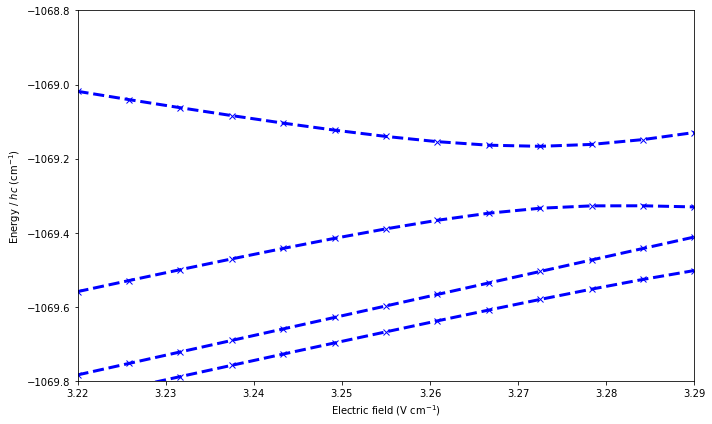

In [13]:
if(PLOT_STARK_MAP):
    # Stark map
    fig, ax = plt.subplots(figsize=(10, 6))

    #idx = np.intersect1d(np.where(n_vals == 55), np.where(m_vals <= 0))
    #for i in tqdm(idx, desc='Highlighting'):
    #    ax.plot(field, 0.01*map1[:, i] * En_h_He /(h * c), c='r', ls='-', lw=1.5)
        
    #idx = np.intersect1d(np.where(n_vals == 55), np.where(m_vals >= 0))
    #for i in tqdm(idx, desc='Highlighting'):
    #    ax.plot(field, 0.01*map1[:, i] * En_h_He /(h * c), c='b', ls='-', lw=1.5)
    
    #for s0 in trange(np.shape(map1)[1], desc='Plotting'):
    #    ax.plot(field, map1[:, s0] * (En_h_He / h) / 10**9, c='b', ls='-', marker='', lw=3)
    
    state_56s = 55**2
    states = [state_56s, state_56s-1, state_56s-2, state_56s-3]
    for s0 in trange(np.shape(map1)[1], desc='Plotting'):
        if s0 in states:
            ax.plot(field, map1[:, s0] * (En_h_He / h) / 10**9, c='b', ls='--', marker='x', lw=3)

    if(HIGHLIGHT_STARK_MAP_PLOT):
    # highlight (assuming states do not cross)
        idx = np.intersect1d(np.where(n_vals == 40), np.where(L_vals == 0))
        for i in tqdm(idx, desc='Highlighting'):
            ax.plot(field, map1[:, i] * (En_h_He / h) / 10**9, c='r', ls='-', lw=1.5)

    # format
    ax.set_ylim(-1069.8, -1068.8)
    ax.set_xlim(3.22, 3.29)
    ax.set_xlabel('Electric field (V cm$^{-1}$)')
    ax.set_ylabel('Energy / $h c$ (cm$^{-1}$)')
    plt.tight_layout()
    # output
    if SAVE_STARK_MAP_PLOT==True:
        # Create fileaname for Stark map
        filename = "StarkMapPlot_n_" + str(nmin) + "-" + str(nmax) + \
        "_E_" + str(np.min(field)).replace('.', '-') + "_" + str(np.max(field)).replace('.', '-') + "_" + str(len(field)) + \
        "_B_" + str(B_z*1E3).replace('.', '-') + ".png"
        # Get images directoy, create it if it doesn't exist
        directory = getImagesDir()
        # Save Stark map to file
        fileout = os.path.join(directory, filename)
        plt.savefig(fileout)
    plt.show()
    plt.show()

# Write and Read files

In [69]:
55-get_qd(S, [55], [1], [2])[0]

54.931645891323221

In [61]:
En_h_He

4.3591471215799256e-18

In [73]:
n_1, l_1, m_1 = 5-get_qd(S, [5], [0], [1])[0], 0, 0
n_2, l_2, m_2 = 5-get_qd(S, [5], [1], [2])[0], 1, -1
rmin = 0.65
step = 0.005
rad_overlap(n_1, n_2, l_1, l_2, rmin, step, p=1.0)

33.32409581817284

In [74]:
ang_overlap(l_1, l_2, m_1, m_2, 'crossed', [0,-1,+1])

0.408248290463863

In [76]:
rad_overlap(n_1, n_2, l_1, l_2, rmin, step, p=1.0) * ang_overlap(l_1, l_2, m_1, m_2, 'crossed', [0,-1,+1])

13.60450514902303

In [3]:
n1, l1 = 70, 0
n2, l2 = 70, 1
rmin = 0.65
step = 0.001
rad_overlap(n1, n2, l1, l2, rmin, step, p=1.0)

7349.251267433513

In [10]:
n1, l1 = 70, 0
n2, l2 = 70, 1
rmin = 0.65
step = 0.0001
rad_overlap(n1, n2, l1, l2, rmin, step, p=1.0)

7349.251423908925

In [33]:
get_qd(1, [55,55,55,55,55,55], [0,1,2,3,4,5], [1,2,3,4,5,6])

array([  2.96669286e-01,   6.83541087e-02,   2.88922692e-03,
         4.46804324e-04,   1.26878367e-04,   4.85866290e-05])

In [11]:
print(n_vals)
print(L_vals)
print(J_vals)

[54 54 54 ..., 56 56 56]
[ 0  1  1 ..., 55 55 55]
[ 1  2  2 ..., 56 56 56]
